# ノート 2: 特徴量の作成

### 目標: 特徴量の作成がなぜ必要か、どのように作成するのかを理解しましょう

### 背景

ノート 1 では SEVIR データセットのストーム事例の画像の一部を見てきました。
ML はデータセットの画像の全ピクセルを予測変数に設定してモデルに入力することもできますが、
ピクセルデータのままではデータサイズが非常に大きくなります（1 つの可視画像だけでも 589824 個のピクセルが含まれます）。
そこで、画像から何らかの統計量を特徴量にしてデータを削減し予測変数として入力するのが一般的です。

### 問題設定の復習

このチュートリアルで扱う 2 つの問題設定を確認しましょう。

1. 画像は雷雲を含むかどうか？
2. 画像にはいくつの雷光が含まれるか？

特徴量とする統計量を選ぶには ML の問題設定を考慮することが重要です。

GOES 衛星の雷検出器のように発雷のデータを直接入手できないような場合を考えてみましょう。
この場合は雷を直接予測するのではなく、雷検出器が観測している何等かの観測値を ML モデルで予測することになるでしょう。
雷ではない値を予測しても役に立たないと思うかもしれませんが、
雷検出器がなかった GEOS-16 以前（2016 年 11 月以前）に観測されたデータを （雷ではない観測値で学習させた） ML モデルで予測することで
雷検出器がない期間についても雷の気候場を作成できるのではと期待できます。

他にもレーダーによる直接の観測データが得られない場合に、別の観測量でモデルを学習させることも考えられます。
例えば、NASA の TERRA プロジェクトが 1999 年から全球観測しているデータを入力として学習させたモデルからは何が予測できるでしょうか？
MODIS の画像が[このページ](https://worldview.earthdata.nasa.gov/)で見ることができます。
この観測データを入力として発雷の有無が予測できたらどんなことが分かるでしょうか？想像してみてください。


### Step 1: パッケージのインポートとデータの読み込み


In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# ヘルパー関数
import sys

sys.path.insert(1, "../scripts/")
from aux_functions import plot_feature_loc

%config InlineBackend.figure_format = 'retina'

In [2]:
# データ（1つのストームイベント）の読み込み
ds = xr.open_dataset("../datasets/sevir/onestorm.nc")

このデータセットに含まれるピクセルの数を数えてみましょう。


In [3]:
# 4つの観測画像について足し合わせます
print(
    "{} pixels".format(
        ds.x.shape[0] * ds.y.shape[0]  # visible
        + ds.x2.shape[0] * ds.y2.shape[0]  # water_vapor
        + ds.x3.shape[0] * ds.y3.shape[0]  # clean_infrared
        + ds.x4.shape[0] * ds.y4.shape[0]  # vil
    )
)

776448 pixels


ピクセル値を全て予測変数にした場合は 75 万個以上の予測変数を入力に使うことになってしまいあまりに多すぎます。
いくつかの統計量を抽出して予測変数として使う必要がある理由が分かってきたでしょうか。


### Step 2: パーセンタイル値の選択

例えば平均値のような統計量をひとつ求めて入力変数にして ML モデルを実行すればよいと思うかもしれません。
確かにすぐにモデルの学習を始めるには手っ取り早い方法かもしれませんが、まず気象学の知識を基にしてデータから調べたい問題に関して情報が得られないか考えてみましょう。

例えば衛星画像データから得られる積乱雲についての関係から以下の情報が得られるでしょう。

- 可視画像の反射因子が大きいほど積乱雲の背が高く深い対流雲であると考えられる。
- 地表では可視画像の反射因子が小さくなる。
- 水蒸気画像の輝度温度は深い対流雲で小さく雲頂の表面温度が低い。
- 水蒸気画像の輝度温度は浅い対流雲では大きく雲頂の表面温度は高くなる。
- 赤外画像についても水蒸気画像と同じく雲の高さと対流の深さが分かる。
- 鉛直積算水蒸気量は上昇流が大きいほど大きくなる。

このデータ「解釈」に加えて、背が高く激しい対流を伴う積乱雲は一般に発雷を伴う可能性が高いという知識を考慮すると、
平均値ではなく、パーセンタイルのような各画像データの値の大小関係を反映できる統計量を使う必要があると考えられます。

このノートでは簡単のために 4 種類の画種すべてで同じパーセンタイルを使用します。
さきほど考えたストームの特性を大小関係として表現できるように
パーセンタイルを [ 最小値, 1%, 10%, 25%, 中央値, 75%, 90%, 99%, 最大値 ] に選びます。

Python では最小値が 0 番目、中央値が 50 番目、最大値が 100 番目になります。パーセンタイルを定義してみましょう。


In [4]:
desired_percentiles = np.array([0, 1, 10, 25, 50, 75, 90, 99, 100])

### Step 3: 画像のパーセンタイルを求める

1 枚の可視画像についてパーセンタイルを求めてみましょう。


In [5]:
# t=0 の xarray.Dataset を取得
ds_sub = ds.isel(t=0)
# 可視画像をスケールして xarray.DataArray を取得
da = ds_sub.visible * 1e-4
da

<xarray.DataArray 'visible' (x: 768, y: 768)>
array([[0.0242    , 0.024     , 0.0226    , ..., 0.056     , 0.0605    ,
        0.1021    ],
       [0.0229    , 0.023     , 0.0228    , ..., 0.09119999, 0.0451    ,
        0.0404    ],
       [0.0236    , 0.0231    , 0.0228    , ..., 0.15179999, 0.0881    ,
        0.0429    ],
       ...,
       [0.0297    , 0.0283    , 0.028     , ..., 0.4782    , 0.4736    ,
        0.48209998],
       [0.0297    , 0.0286    , 0.0289    , ..., 0.479     , 0.4768    ,
        0.4827    ],
       [0.0299    , 0.0302    , 0.0303    , ..., 0.48189998, 0.48079997,
        0.48569998]], dtype=float32)
Dimensions without coordinates: x, y

`NumPy.nanpercentile` 関数を用いてパーセンタイルが計算できます。


In [6]:
# xarray.DataArray は values プロパティでNumPy配列として値が取得できる
percentiles = np.nanpercentile(da.values, desired_percentiles, axis=(0, 1))
percentiles

array([0.0132    , 0.0215    , 0.0325    , 0.0423    , 0.1962    ,
       0.47499999, 0.55979997, 0.68379998, 1.02189994])

### Step 4: 可視化してさらに確認

計算したパーセンタイル値が画像のどこに対応するのかを確認してみましょう。


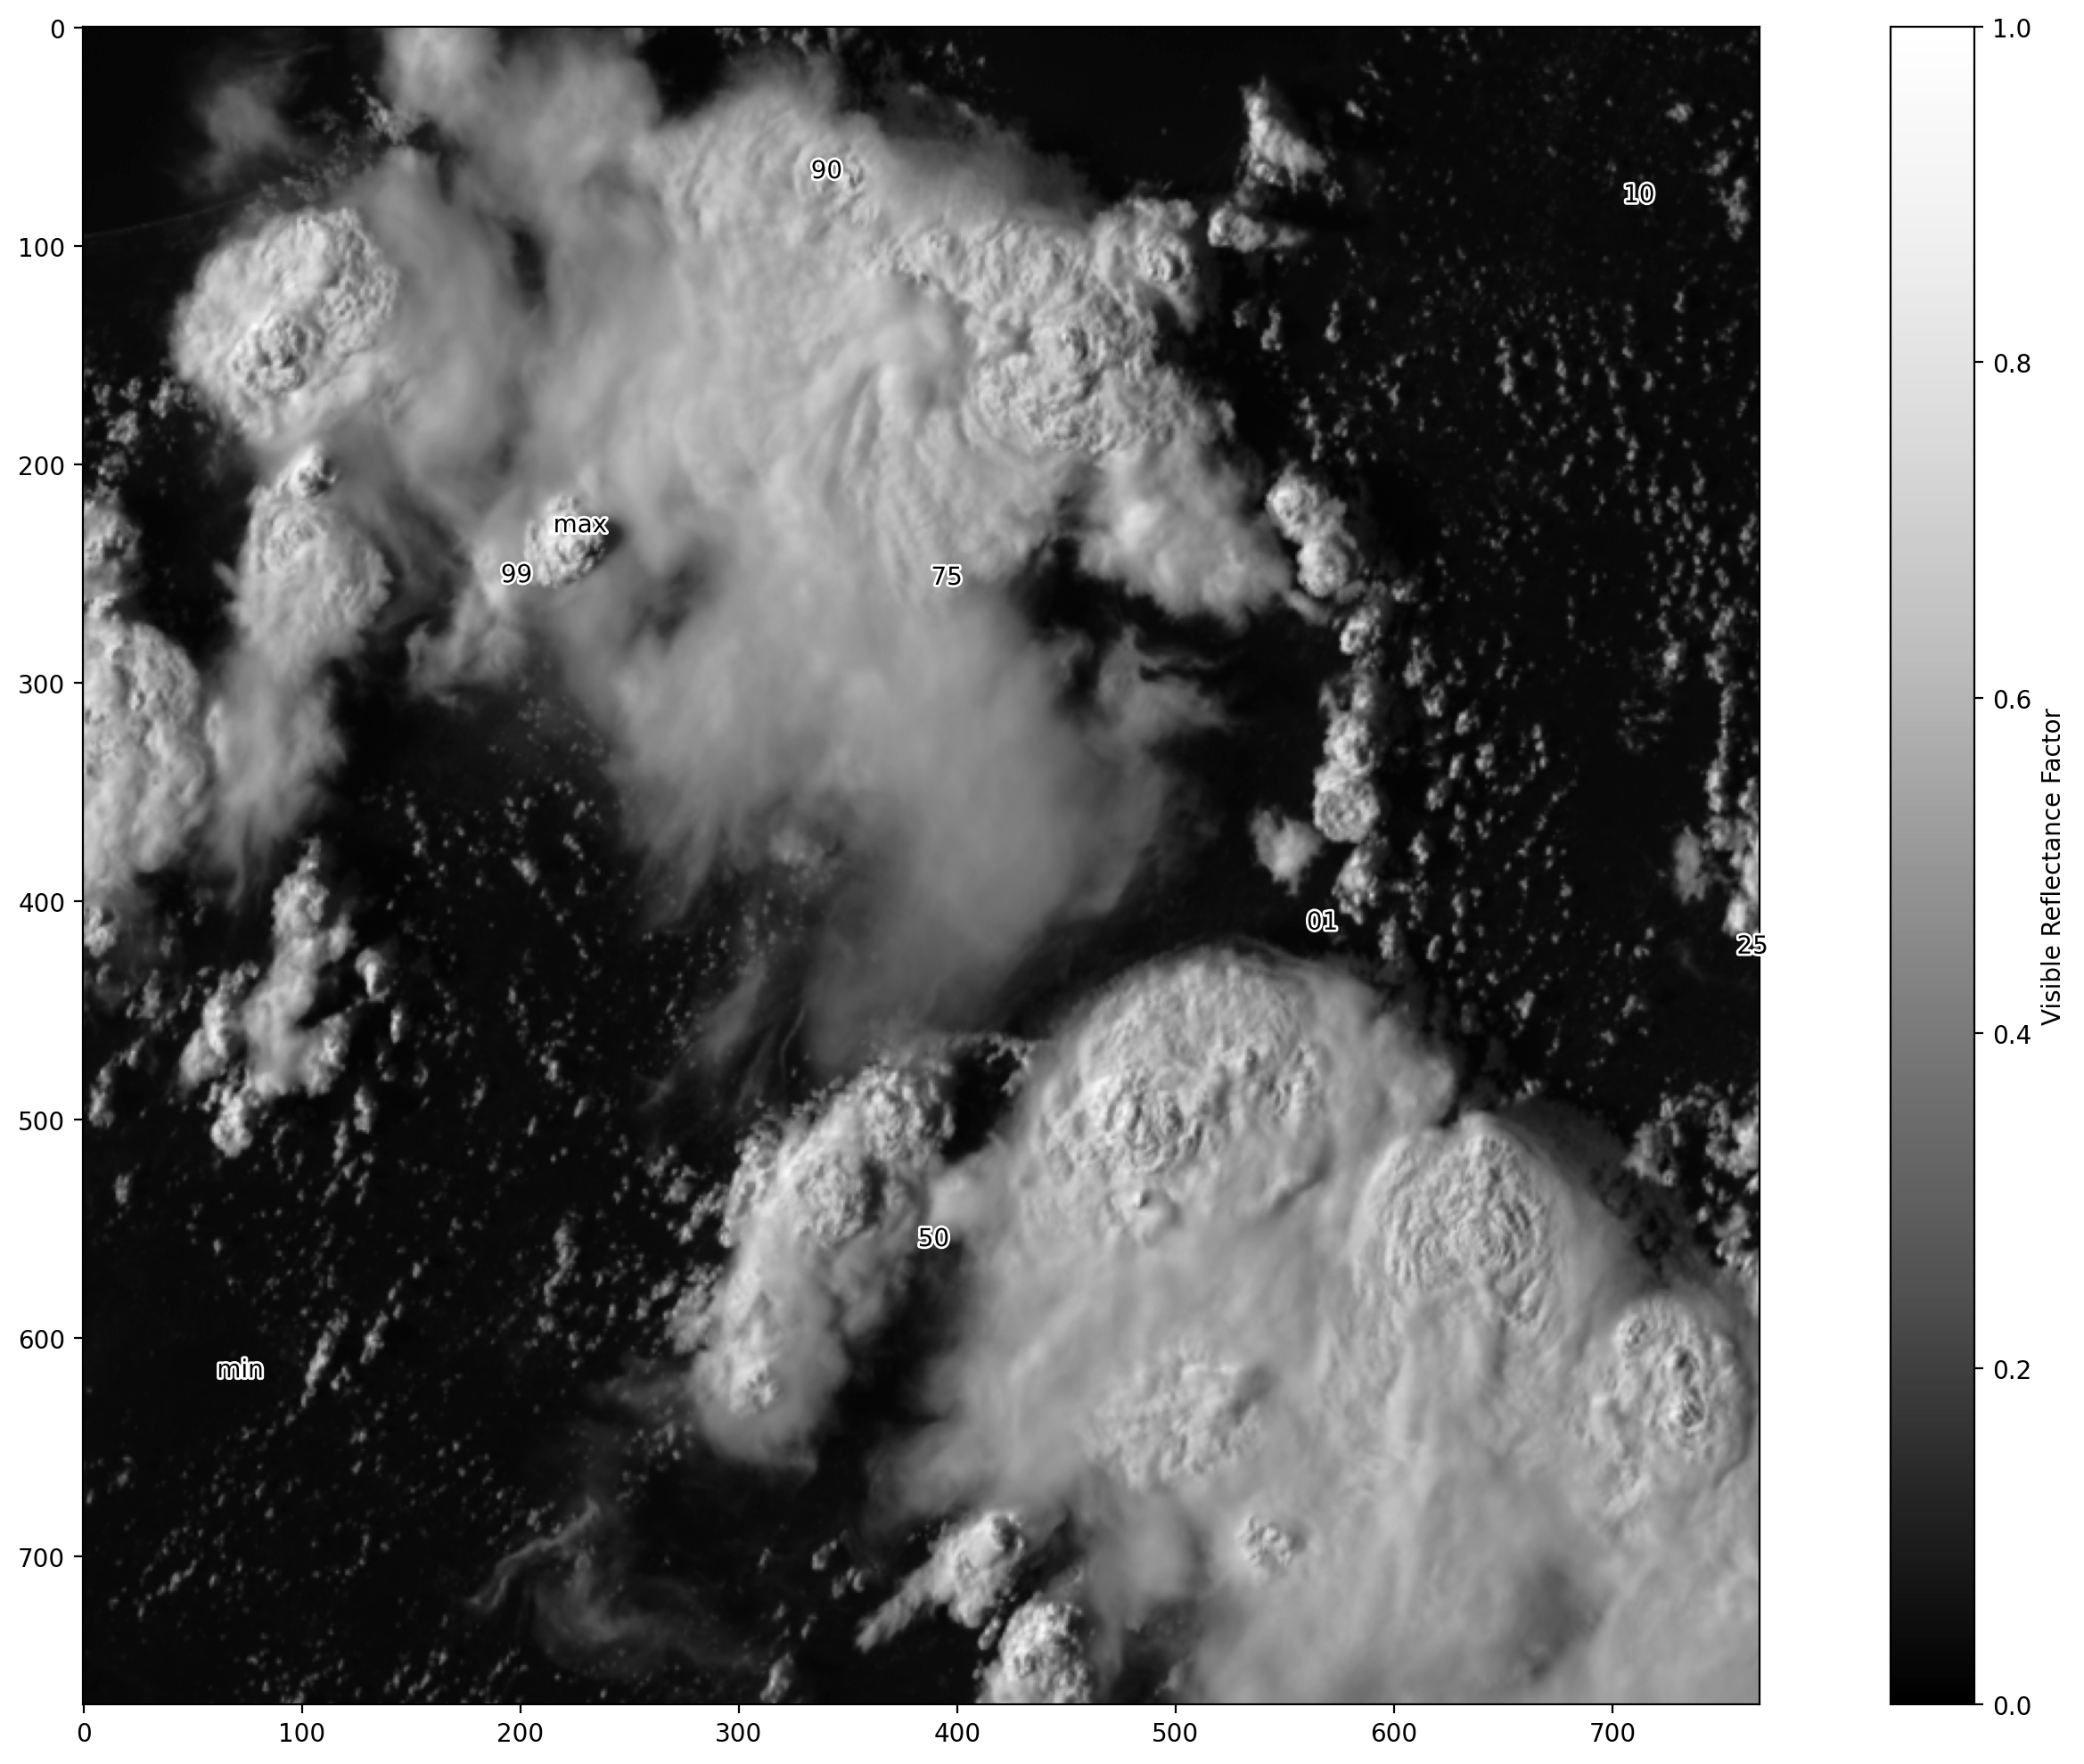

In [7]:
fig, ax = plt.subplots(figsize=(15, 10))
# データをプロット
mappable = ax.imshow(da, cmap="Greys_r", vmin=0, vmax=1)

# パーセンタイル値の位置をプロット（パーセンタイル値はヘルパー関数内で求めている）
plot_feature_loc(da, ax)

fig.colorbar(mappable, label="Visible Reflectance Factor")
fig.tight_layout()

各パーセンタイル値が意味のある地点にプロットされているか確認しましょう。
`min`（最小値）としてプロットされた場所が暗域になっているでしょうか？`max`（最大値）としてプロットされた場所が明域になっているでしょうか？

画像は多数のピクセルの集合で構成されているため、各パーセンタイルに対応するピクセルが 1 つ以上含まれているでしょう。
プロットするコードを何回か再実行してみましょう。ラベルの位置が別の場所に変わったりするはずです。


### Step 5: 複数の画像のパーセンタイルを計算してみよう

データセットには 10000 以上の事例が含まれており、各事例は 5 分間隔で 4 時間分（49 タイムステップ）で構成されているます。
大量のデータから効率的にパーセンタイルを計算する必要がありコードには工夫が必要です。

このノートでは詳しい計算ロジックの説明は省略して計算済みのパーセンタイルデータを使います。


### Step 6: 結果

データセットから特徴量を作成したら結果を一通り見て不自然なデータがないか確認するようにしましょう。
例として水蒸気画像から計算した特徴量（パーセンタイル値）を見てみましょう。

Step 5 で述べたように計算済みのデータが `datasets/sevir` に csv ファイルとして保存してあります。各ファイルは 100MB 以上ありますので扱いには注意してください。
1 列目が日時で 2 列目以降の `q_` とラベル付けしてある値がパーセンタイルです。最終列はその画像内で報告されたストームの事例種別を表しています。

pandas を使って csv を読み込んでみましょう。


In [8]:
import pandas as pd

df = pd.read_csv("../datasets/sevir/WV_stats_master.csv", index_col=0, low_memory=False)
df.head()

,q000,q001,q010,q025,q050,q075,q090,q099,q100,event
2018-03-22 14:10:00,-6149.0,-6037.00,-5853.0,-5707.00,-5498.0,-5306.0,-4997.0,-3637.63,-3325.0,NaN
2018-03-22 14:15:00,-6167.0,-6032.00,-5847.0,-5710.00,-5499.0,-5295.0,-4989.0,-3695.63,-3295.0,NaN
2018-03-22 14:20:00,-6188.0,-6030.37,-5846.0,-5711.25,-5499.0,-5268.0,-4949.3,-3742.00,-3346.0,NaN
2018-03-22 14:25:00,-6191.0,-6025.00,-5848.0,-5712.00,-5498.0,-5246.0,-4894.0,-3751.63,-3358.0,NaN
2018-03-22 14:30:00,-6201.0,-6018.00,-5840.0,-5716.00,-5506.0,-5234.0,-4833.0,-3711.63,-3415.0,NaN


最初の 5 行を表示しました。値は輝度温度（degC）ですが 100 倍した値になっているので$10^{-2}$倍してスケールを戻す必要があります。


In [9]:
# 最後のevent列は文字列なので演算の際には [:-1] として除く
keys = list(df.keys()[:-1])
df[keys] = df[keys] * 1e-2
df.head()

,q000,q001,q010,q025,q050,q075,q090,q099,q100,event
2018-03-22 14:10:00,-61.49,-60.3700,-58.53,-57.0700,-54.98,-53.06,-49.970,-36.3763,-33.25,NaN
2018-03-22 14:15:00,-61.67,-60.3200,-58.47,-57.1000,-54.99,-52.95,-49.890,-36.9563,-32.95,NaN
2018-03-22 14:20:00,-61.88,-60.3037,-58.46,-57.1125,-54.99,-52.68,-49.493,-37.4200,-33.46,NaN
2018-03-22 14:25:00,-61.91,-60.2500,-58.48,-57.1200,-54.98,-52.46,-48.940,-37.5163,-33.58,NaN
2018-03-22 14:30:00,-62.01,-60.1800,-58.40,-57.1600,-55.06,-52.34,-48.330,-37.1163,-34.15,NaN


各列の統計量は `.descripe` メソッドで求めることができます。


In [10]:
df.describe()

,q000,q001,q010,q025,q050,q075,q090,q099,q100
count,618992.000000,618992.000000,618992.000000,618992.000000,618992.000000,618992.000000,618992.000000,618992.000000,618992.000000
mean,-57.094519,-52.226658,-46.171140,-41.440475,-35.875888,-31.186900,-28.204743,-25.287387,-23.898188
std,12.577898,12.062988,11.812426,11.176882,9.858604,8.323602,7.263426,6.273164,5.853209
min,-183.120000,-81.920000,-77.410000,-73.440000,-71.030000,-68.260000,-67.280000,-64.530000,-60.540000
25%,-66.890000,-61.490000,-54.960000,-49.530000,-42.070000,-35.420000,-32.153000,-29.140000,-27.690000
50%,-57.760000,-53.293700,-46.610000,-40.720000,-34.250000,-30.160000,-27.570000,-24.900000,-23.620000
75%,-49.350000,-44.450000,-37.280000,-32.740000,-28.860000,-25.580000,-23.360000,-21.050000,-19.920000
max,-11.980000,-11.630000,-10.330000,-8.600000,-7.460000,-5.950000,-5.050000,-3.910000,22.870000


統計量の確認は不自然なデータがないかチェックするのに役立ちます。例えば、`min` の行を見てみると外れ値があるのが分かるでしょうか。
q000 の最小値は-183 ですが q001 の最小値-81 より 100 度以上低くなっています。この外れ値を除外しましょう。


In [11]:
# q000列が-100以下の行を除く
df = df.where(df.q000 > -100)
df.describe()

,q000,q001,q010,q025,q050,q075,q090,q099,q100
count,618991.000000,618991.000000,618991.000000,618991.000000,618991.000000,618991.000000,618991.00000,618991.000000,618991.000000
mean,-57.094315,-52.226642,-46.171117,-41.440452,-35.875863,-31.186876,-28.20472,-25.287367,-23.898263
std,12.576888,12.062991,11.812422,11.176875,9.858592,8.323587,7.26341,6.273151,5.852912
min,-90.990000,-81.920000,-77.410000,-73.440000,-71.030000,-68.260000,-67.28000,-64.530000,-60.540000
25%,-66.890000,-61.490000,-54.960000,-49.530000,-42.070000,-35.420000,-32.15300,-29.140000,-27.690000
50%,-57.760000,-53.293700,-46.610000,-40.720000,-34.250000,-30.160000,-27.57000,-24.900000,-23.620000
75%,-49.350000,-44.450000,-37.280000,-32.740000,-28.860000,-25.580000,-23.36000,-21.050000,-19.920000
max,-11.980000,-11.630000,-10.330000,-8.600000,-7.460000,-5.950000,-5.05000,-3.910000,12.390000


表で統計量を見るのもよい方法ですが、ヒストグラムにして分布を可視化してみましょう。
外れ値を見つけるためにも可視化するのは良い方法です。


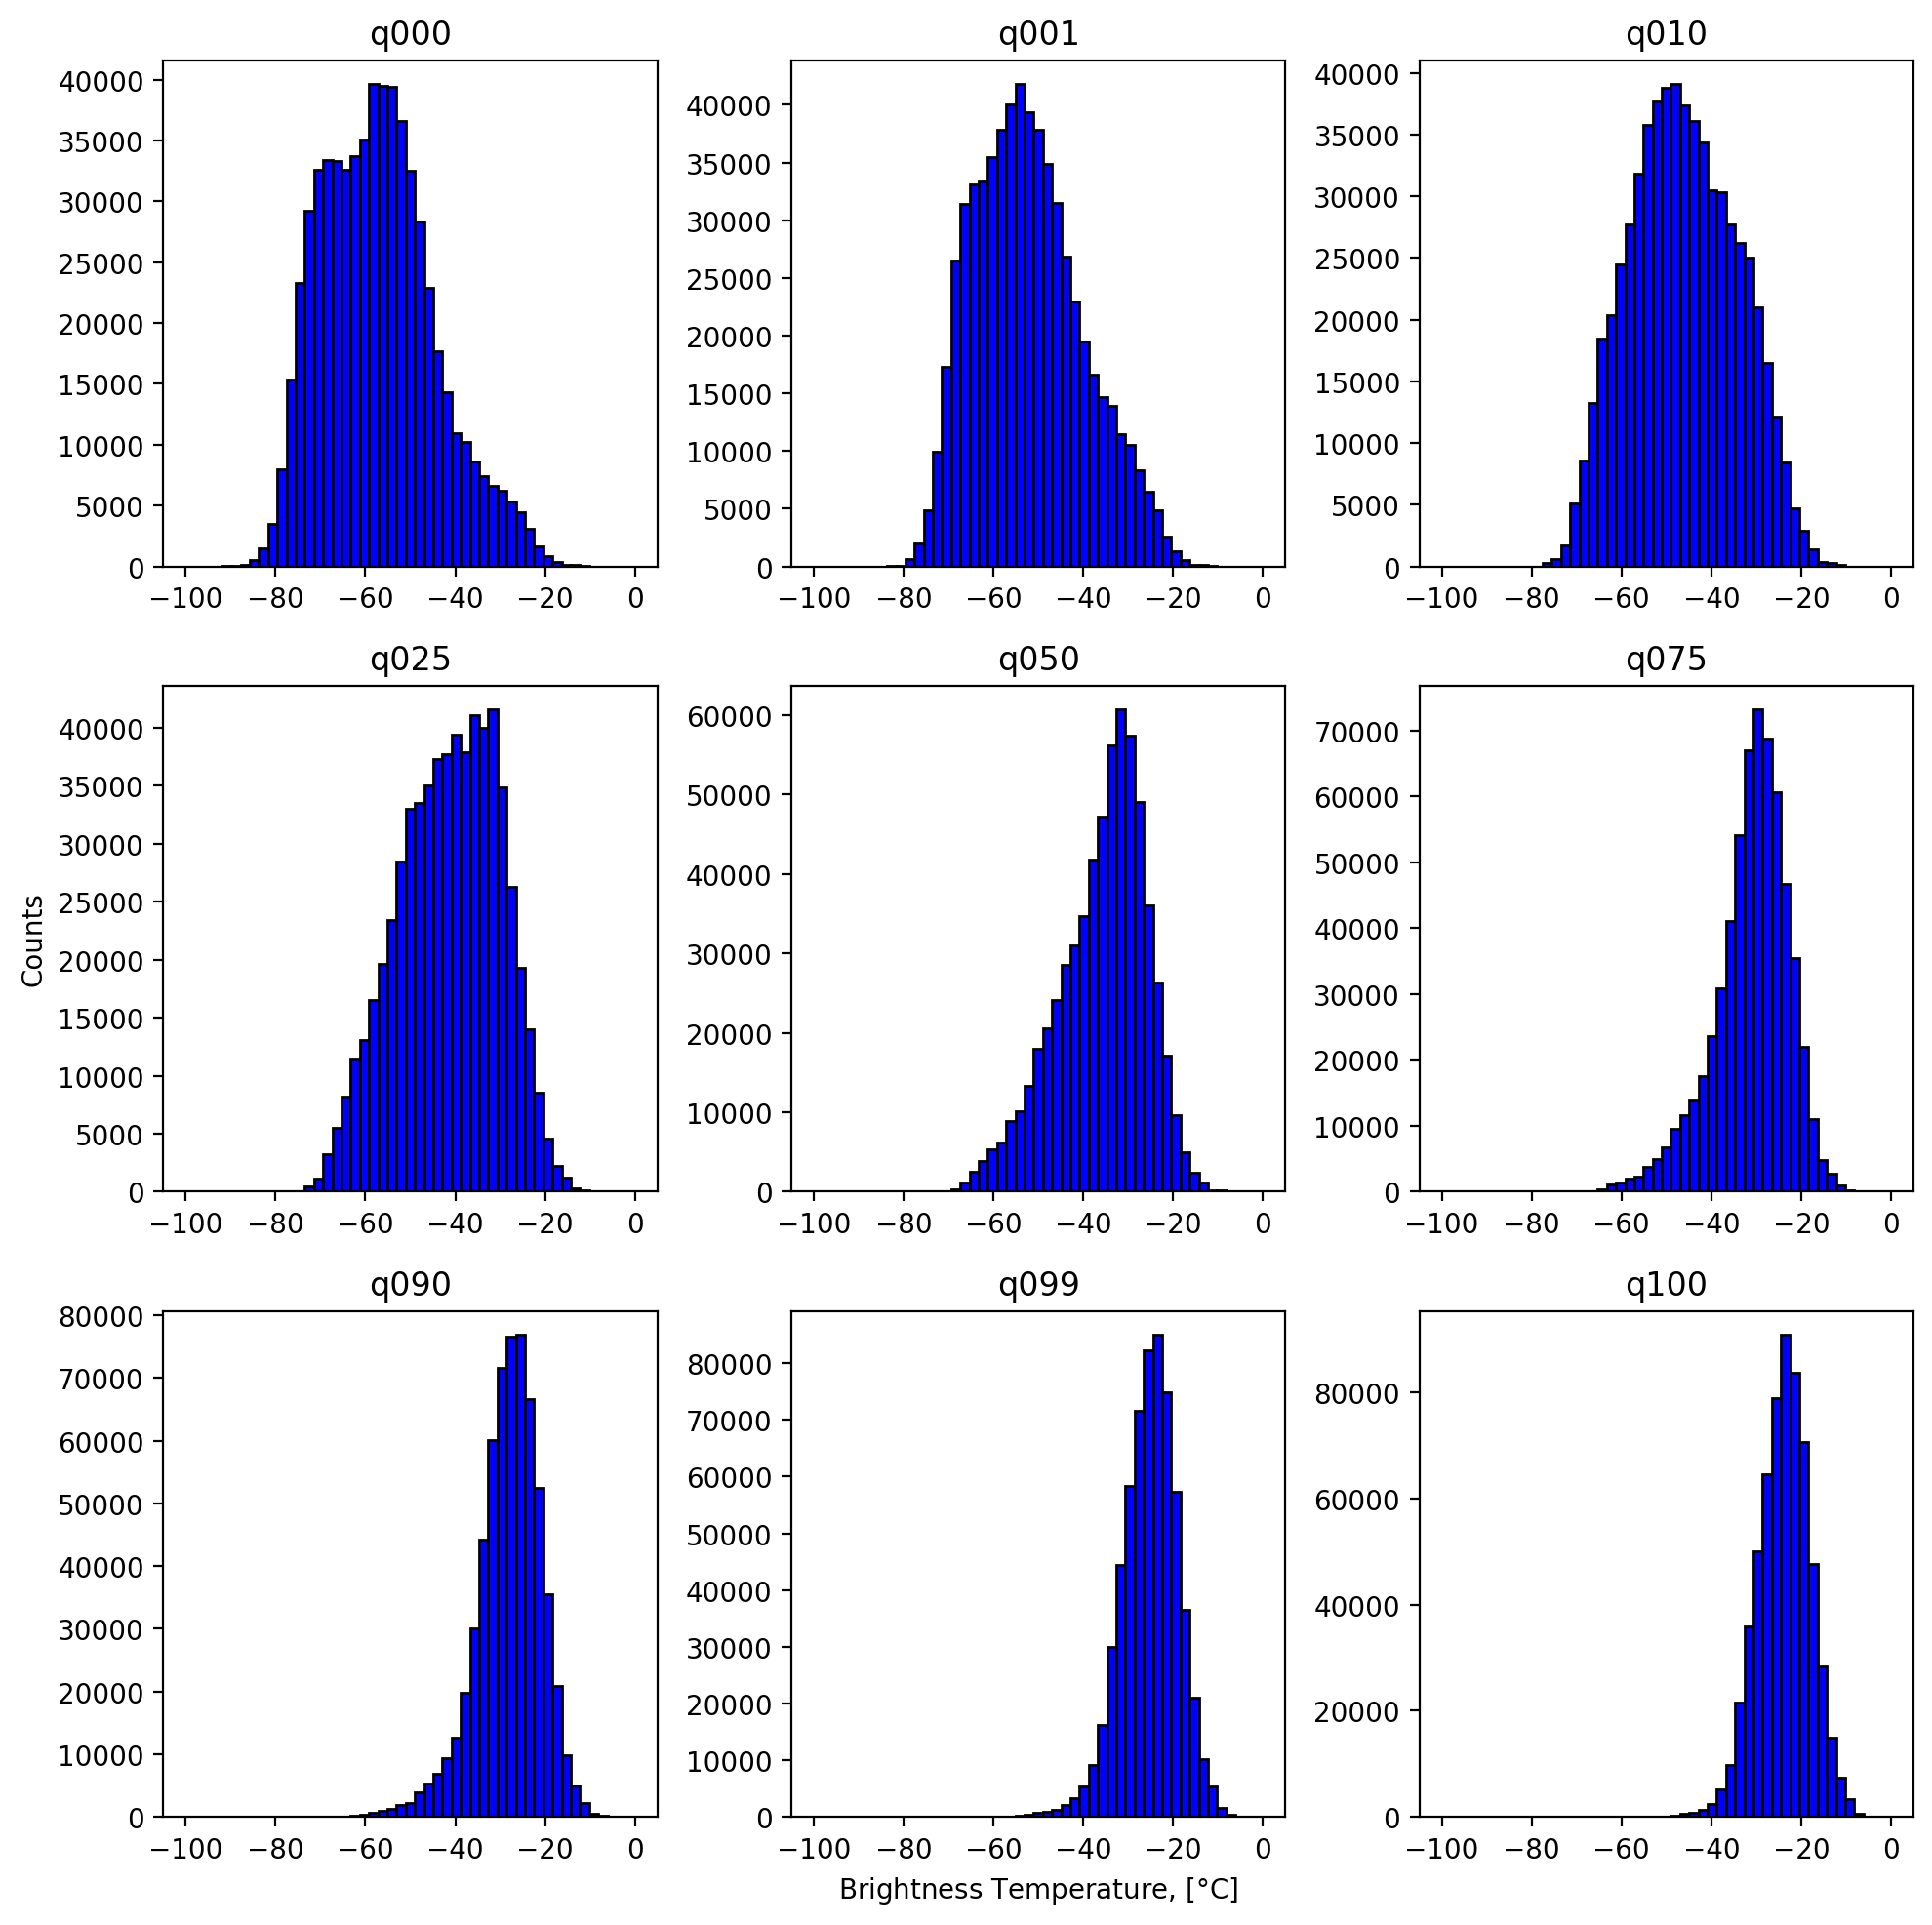

In [12]:
# -100度から0度まで1度刻みのbinにする
bins = np.linspace(-100, 0)

# 3x3の枠を作成
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
# ループで扱いやすいようにaxesを1次元に
axes = axes.ravel()

for i, ax in enumerate(axes):
    key = keys[i]  # パーセンタイルの列のラベルインデックス
    ax.hist(df[key], bins=bins, color="b", edgecolor="k")
    ax.set_title(key)

axes[3].set_ylabel("Counts")
axes[7].set_xlabel(r"Brightness Temperature, [$\degree$C]")

fig.tight_layout()

練習のために、他の変数（特徴量）についても水蒸気画像のパーセンタイルと同じ処理をしてみましょう。
特徴量の求め方について理解できたらノート 3 に進みます。ノート 3 ではデータセットを訓練データ、評価データ、テストデータに分割する方法について学習します。


#### 赤外画像の例

データを読み込んでスケールを戻します。


In [13]:
df = pd.read_csv("../datasets/sevir/IR_stats_master.csv", index_col=0, low_memory=False)
df[df.keys()[:-1]] = df[df.keys()[:-1]] * 1e-2
df.head()

,q000,q001,q010,q025,q050,q075,q090,q099,q100,event
2018-03-22 14:10:00,-60.26,-59.08,-56.99,-55.11,-52.340,-49.94,-44.930,-19.3126,-4.70,NaN
2018-03-22 14:15:00,-60.40,-59.07,-56.95,-55.19,-52.410,-49.76,-44.703,-20.9989,-8.59,NaN
2018-03-22 14:20:00,-60.62,-59.11,-56.96,-55.22,-52.420,-49.47,-44.000,-23.1952,-10.63,NaN
2018-03-22 14:25:00,-60.80,-59.06,-56.98,-55.26,-52.445,-49.15,-43.300,-22.4363,-8.91,NaN
2018-03-22 14:30:00,-61.06,-59.05,-56.92,-55.32,-52.560,-48.94,-42.870,-20.0300,-8.85,NaN


統計量を算出します。


In [14]:
df.describe()

,q000,q001,q010,q025,q050,q075,q090,q099,q100
count,618992.000000,618992.000000,618992.000000,618992.000000,618992.00000,618992.000000,618992.000000,618992.000000,618992.000000
mean,-52.404928,-45.985022,-35.928427,-26.528165,-13.77234,-2.155585,5.187578,12.004392,15.619968
std,18.185136,19.842321,22.339042,23.351548,22.76791,20.062192,17.137333,13.504437,11.797521
min,-222.400000,-82.770000,-77.710000,-74.040000,-71.47000,-68.250000,-66.740000,-61.970000,-58.960000
25%,-65.120000,-59.893700,-52.647000,-45.420000,-31.55500,-15.350000,-5.183000,4.370000,8.940000
50%,-55.530000,-50.723700,-41.410000,-29.750000,-13.16000,0.702500,9.237000,15.300000,17.750000
75%,-45.290000,-38.087400,-22.700000,-9.490000,5.38500,14.712500,18.470000,21.360000,23.150000
max,30.430000,35.236300,39.950000,44.150000,47.61000,49.680000,51.190000,53.233700,61.130000


表から q000 に外れ値があることが分かります。外れ値を含むデータを除きます。


In [15]:
df = df.where(df.q000 > -100)
df.describe()

,q000,q001,q010,q025,q050,q075,q090,q099,q100
count,618988.000000,618988.000000,618988.000000,618988.000000,618988.000000,618988.000000,618988.000000,618988.000000,618988.000000
mean,-52.404191,-45.984969,-35.928367,-26.528125,-13.772311,-2.155565,5.187592,12.004376,15.619956
std,18.182353,19.842354,22.339087,23.351594,22.767937,20.062214,17.137356,13.504473,11.797557
min,-92.790000,-82.770000,-77.710000,-74.040000,-71.470000,-68.250000,-66.740000,-61.970000,-58.960000
25%,-65.120000,-59.893700,-52.647000,-45.420000,-31.555000,-15.350000,-5.183000,4.370000,8.940000
50%,-55.530000,-50.723700,-41.410000,-29.750000,-13.160000,0.702500,9.237000,15.300000,17.750000
75%,-45.290000,-38.087400,-22.700000,-9.490000,5.385000,14.712500,18.470000,21.360000,23.150000
max,30.430000,35.236300,39.950000,44.150000,47.610000,49.680000,51.190000,53.233700,61.130000


ヒストグラムを描いてみます。


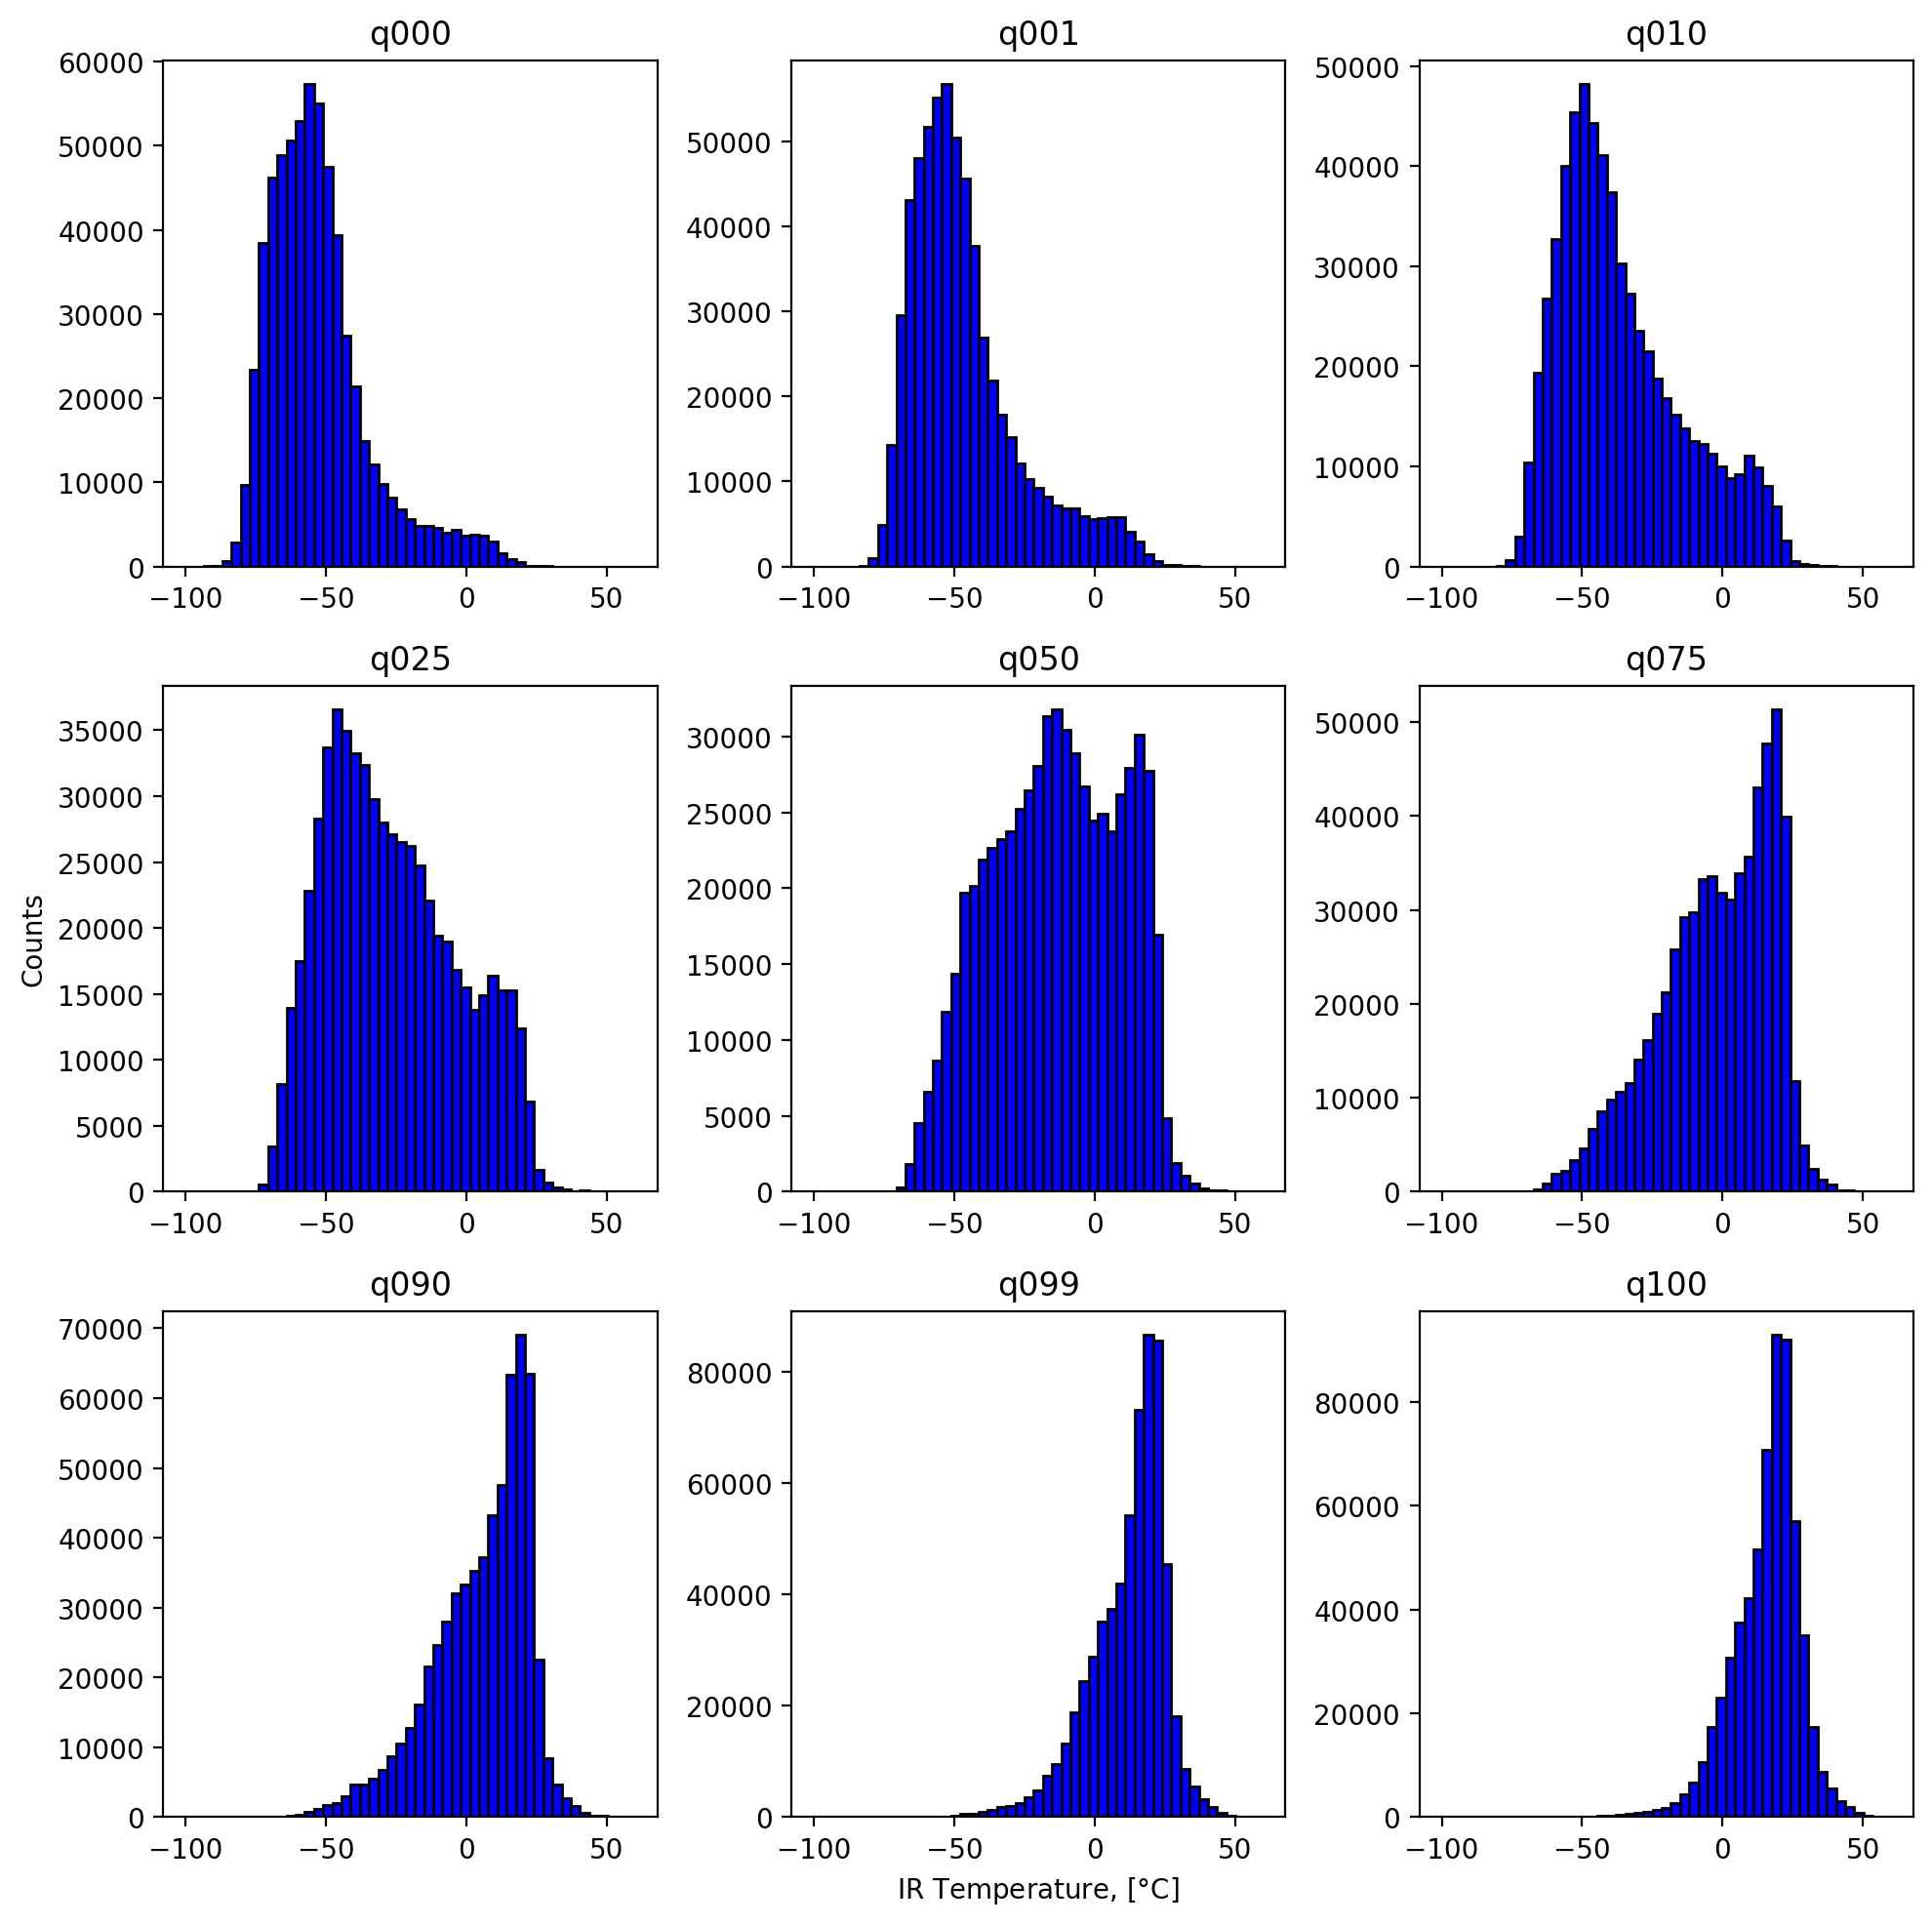

In [16]:
def plot(df):
    bins = np.linspace(-100, 60)

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()
    for i, ax in enumerate(axes):
        key = keys[i]  # パーセンタイルの列のラベルインデックス
        ax.hist(df[key], bins=bins, color="b", edgecolor="k")
        ax.set_title(key)

    axes[3].set_ylabel("Counts")
    axes[7].set_xlabel(r"IR Temperature, [$\degree$C]")

    fig.tight_layout()


plot(df)